# Links only graph in postgres

A simple graph using a single table that lists edges.

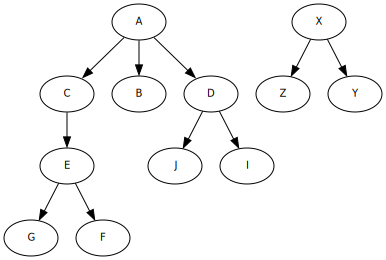

In [85]:
import psycopg
import graphviz

def execute(commands):
    with psycopg.connect("dbname=thingtest user=vieglais") as cn:
        with cn.cursor() as csr:
            for s in commands:
                csr.execute(s)
                cn.commit()

sql = [
    "DROP TABLE IF EXISTS links;",
    """CREATE TABLE links(
        id int PRIMARY KEY,
        a VARCHAR,
        b VARCHAR
    );""",
    """INSERT INTO links VALUES
    (0, 'A', 'B'),
    (1, 'A', 'C'),
    (2, 'A', 'D'),
    (3, 'C', 'E'),
    (4, 'E', 'F'),
    (5, 'E', 'G'),
    (6, 'D', 'I'),
    (7, 'D', 'J'),
    (8, 'X', 'Y'),
    (9, 'X', 'Z');
    """
]

execute(sql)

def show_graph(links, highlight=[]):
    dst = [
        "digraph {", 
        "node [fontname=\"JetBrains Mono\", fontsize=10];",
    ]
    nodes = set()
    for l in links:
        nodes.add(l[0])
        nodes.add(l[1])
    for n in nodes:
        if n in highlight:
            dst.append(f"{n} [color=red];")
        else:
            dst.append(f"{n}")
    for l in links:
        if len(l) > 2:
            dst.append(f"{l[0]} -> {l[1]} [label=\"{l[2]}\"];")
        else:
            dst.append(f"{l[0]} -> {l[1]};")
    dst.append("}")
    return graphviz.Source("\n".join(dst))

def highlight_graph(highlight=[]):
    nodes = doquery("SELECT a,b FROM links;")
    return show_graph(nodes, highlight=highlight)

def doquery(sql):
    with psycopg.connect("dbname=thingtest user=vieglais") as cn:
        with cn.cursor() as csr:
            result = csr.execute(sql).fetchall()
    return result

highlight_graph()

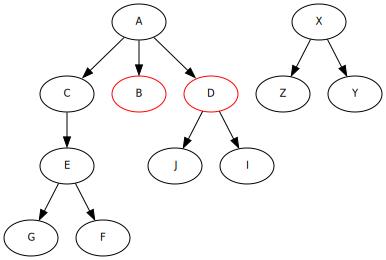

In [86]:
# Siblings of C
q = """
SELECT b FROM links WHERE links.a IN (SELECT a from links WHERE links.b='C') AND links.b != 'C';
"""
rows = doquery(q)
highlight_graph([row[0] for row in rows])

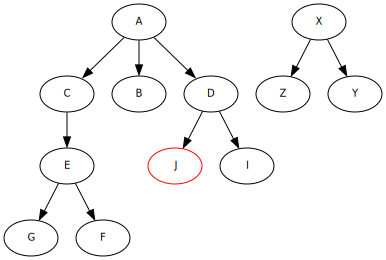

In [87]:
# Siblings as a user defined function
q = """
CREATE OR REPLACE FUNCTION siblings(node VARCHAR)
    RETURNS TABLE (
        id VARCHAR
    ) AS $$
BEGIN
    RETURN QUERY 
    SELECT b 
    FROM links 
    WHERE links.a IN (SELECT a from links WHERE links.b = node) AND links.b != node;
END; $$
LANGUAGE 'plpgsql';
"""
execute([q,])
highlight_graph([row[0] for row in doquery("SELECT siblings('I')")])

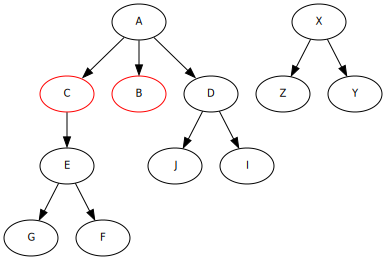

In [89]:
highlight_graph([row[0] for row in doquery("SELECT siblings('D')")])

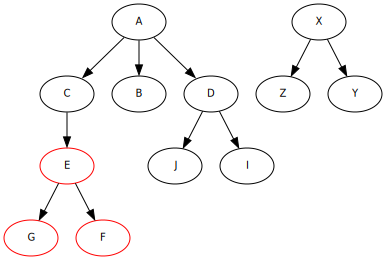

In [90]:
# descendants of C as a user defined function
q = """CREATE OR REPLACE FUNCTION descendants(node VARCHAR)
    RETURNS TABLE (
        b VARCHAR
    )
AS $$
    WITH RECURSIVE linker(b) AS (
        SELECT b
        FROM links
        WHERE a = node
    UNION
        SELECT links.b
        FROM links
        JOIN linker ON links.a = linker.b
    )
    SELECT b FROM linker;
$$ LANGUAGE SQL;
"""
execute([q, ])
rows = doquery("SELECT descendants('C');")
highlight_graph([row[0] for row in rows])


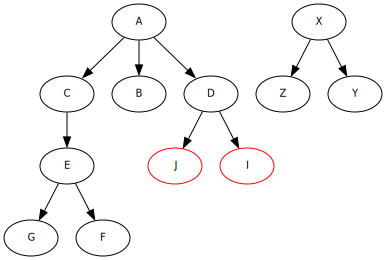

In [91]:
# descendants of D
highlight_graph([row[0] for row in doquery("SELECT descendants('D')")])

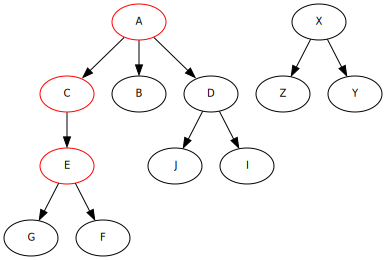

In [92]:
# ancestors of F
q = """
CREATE OR REPLACE FUNCTION ancestors(node VARCHAR)
    RETURNS TABLE (
        a VARCHAR
    )
AS $$
WITH RECURSIVE linker(a) AS (
    SELECT a
    FROM links
    WHERE b = node
UNION
    SELECT links.a
    FROM links
    JOIN linker ON links.b = linker.a
)
SELECT * FROM linker;
$$ LANGUAGE SQL;
"""
execute([q, ])
rows = doquery("SELECT ancestors('F')")
highlight_graph([row[0] for row in rows])

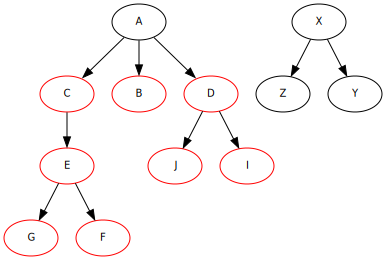

In [93]:
# descendants of ancestors of E
q = """
SELECT descendants(b.id) FROM (SELECT ancestors('E') AS id) AS b;
"""
highlight_graph([row[0] for row in doquery(q)])

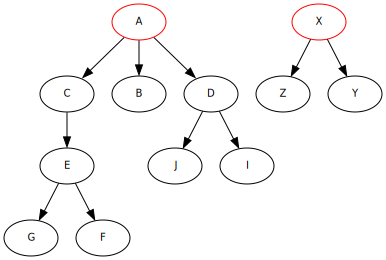

In [95]:
# distinct graphs
# This is the list elements where links.a never appears in links.b
# Note that this only works for directed graphs
q = """
SELECT links.a FROM links WHERE links.a NOT IN (SELECT links.b FROM links);
"""
highlight_graph([row[0] for row in doquery(q)])

In [126]:

# penultimate ancestor of G
q = """
SELECT * FROM links WHERE links.b IN (SELECT ancestors('G'))
"""
doquery(q)


[(1, 'A', 'C'), (3, 'C', 'E')]

In [ ]:
# number of elements in a graph
